In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Football_Pitch import draw_football_pitch
from moviepy.video.io.bindings import mplfig_to_npimage

%matplotlib inline

In [2]:
data = pd.read_csv("../Data/Last_Row_Data/liverpool_2019.csv")
data = data.drop("Unnamed: 0", axis=1)
data["x"] *= 1.2
data["y"] *= 0.8
data.head()

bgcolor        dx        dy edgecolor  frame                           play  \
0     NaN  0.000000  0.000000       NaN      0  Liverpool [3] - 0 Bournemouth   
1     NaN  0.185745  1.217580       NaN      1  Liverpool [3] - 0 Bournemouth   
2     NaN  0.178659  1.171133       NaN      2  Liverpool [3] - 0 Bournemouth   
3     NaN  0.171573  1.124685       NaN      3  Liverpool [3] - 0 Bournemouth   
4     NaN  0.164488  1.078238       NaN      4  Liverpool [3] - 0 Bournemouth   

   player  player_num team          x          y    z  
0       0         NaN  NaN  55.673469   8.907563  0.0  
1       0         NaN  NaN  55.896363   9.881627  0.0  
2       0         NaN  NaN  56.110754  10.818533  0.0  
3       0         NaN  NaN  56.316642  11.718281  0.0  
4       0         NaN  NaN  56.514027  12.580872  0.0

In [3]:
goals = list(set(data["play"]))
goals

['Liverpool [1] - 0 Wolves',
 'Fulham 0 - [1] Liverpool',
 'Liverpool [4] - 0 Barcelona',
 'Liverpool [2] - 0 Porto',
 'Liverpool [1] - 0 Everton',
 'Leicester 0 - [3] Liverpool',
 'Bayern 0 - [1] Liverpool',
 'Liverpool [2] - 0 Man City',
 'Liverpool [2] - 1 Chelsea',
 'Liverpool [1] - 0 Watford',
 'Liverpool [2] - 0 Salzburg',
 'Bournemouth 0 - 3 Liverpool',
 'Southampton 1 - [2] Liverpool',
 'Liverpool [2] - 1 Newcastle',
 'Genk 0 - [3] Liverpool',
 'Porto 0 - [2] Liverpool',
 'Liverpool [2] - 0 Everton',
 'Liverpool [3] - 0 Bournemouth',
 'Liverpool [3] - 0 Norwich']

In [4]:
def draw_frame(goal, voronoi=True, voronoi_step=2):
    def draw_frame_helper(t):
        frame = int(t * 25)

        fig, ax = plt.subplots()
        ax.axis("equal")
        ax.set_ylim(bottom=-5, top=85)
        ax.set_xlim(left=-9, right=129)
        draw_football_pitch(fig, ax)

        relevant_rows = data[(data["frame"] == frame) & (data["play"] == goal)]
        relevant_rows.index = range(len(relevant_rows))
        for i in range(len(relevant_rows)):
            row = relevant_rows.iloc[i]
            if row["team"] not in ("attack", "defense"):
                continue
            ax.plot(
                row["x"],
                row["y"],
                ms=15,
                marker="o",
                markeredgecolor=row["edgecolor"],
                markerfacecolor=row["bgcolor"],
            )
            if not np.isnan(row["player_num"]):
                ax.annotate(
                    str(int(row["player_num"])),
                    xy=(row["x"], row["y"] - 0.5),
                    horizontalalignment="center",
                    verticalalignment="center",
                    weight="heavy",
                )

        ball = relevant_rows[
            (relevant_rows["team"] != "attack") & (relevant_rows["team"] != "defense")
        ].iloc[0]
        ax.plot(
            ball["x"],
            ball["y"],
            marker="o",
            ms=5,
            markeredgecolor="black",
            markerfacecolor="white",
        )

        if voronoi:
            liverpool_rows = relevant_rows[relevant_rows["team"] == "attack"]
            other_team_rows = relevant_rows[relevant_rows["team"] == "defense"]
            draw_voronoi(liverpool_rows, other_team_rows, fig, ax, voronoi_step)

        ax.set_title(goal)

        return mplfig_to_npimage(fig)

    return draw_frame_helper

In [32]:
def distance_function(x, y, data):
    def distance_function_helper(a):
        row = data.iloc[a]
        if row["player"] == 0:
            dist = float("inf")
        else:
            dist = ((row["x"] - x) ** 2 + (row["y"] - y) ** 2) ** 0.5
        return dist

    return distance_function_helper


def draw_voronoi(liverpool_data, other_team_data, fig, ax, step):
    for x in np.arange(step / 2.0, 120, step):
        for y in np.arange(step / 2.0, 80, step):
            closest_liverpool_row = liverpool_data.iloc[
                min(
                    range(len(liverpool_data)),
                    key=distance_function(x, y, liverpool_data),
                )
            ]
            closest_other_team_row = other_team_data.iloc[
                min(
                    range(len(other_team_data)),
                    key=distance_function(x, y, other_team_data),
                )
            ]

            liverpool_dist = (
                (closest_liverpool_row["x"] - x) ** 2
                + (closest_liverpool_row["y"] - y) ** 2
            ) ** 0.5
            other_team_dist = (
                (closest_other_team_row["x"] - x) ** 2
                + (closest_other_team_row["y"] - y) ** 2
            ) ** 0.5

            liverpool_prob = other_team_dist / (other_team_dist + liverpool_dist)
            other_team_prob = liverpool_dist / (other_team_dist + liverpool_dist)

            ax.fill(
                [x - step / 2.0, x + step / 2.0, x + step / 2.0, x - step / 2.0],
                [y - step / 2.0, y - step / 2.0, y + step / 2.0, y + step / 2.0],
                fc=(
                    liverpool_prob,
                    liverpool_prob * other_team_prob,
                    other_team_prob,
                    1,
                ),
            )

CPU times: user 4.2 s, sys: 15.6 ms, total: 4.22 s
Wall time: 4.32 s


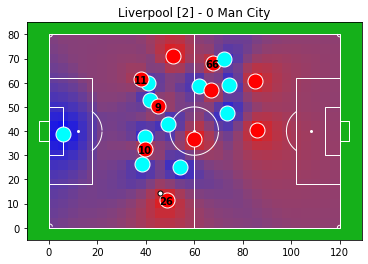

In [33]:
%%time

goal = "Liverpool [2] - 0 Man City"
_ = draw_frame(goal, voronoi=True, voronoi_step=4)(2.68)

In [ ]:
%%time

# Make a video of all the frames
from moviepy.editor import VideoClip

goal = "Liverpool [4] - 0 Barcelona"
t = len(data[(data["play"] == goal) & (data["player"] == 0)]) / 25.0

clip = VideoClip(draw_frame(goal, voronoi=True, voronoi_step=1.25), duration=t)

filename = goal.replace(" ", "_") + ".gif"
clip.write_gif(filename, fps=25)

# filename = goal.replace(" ", "_") + ".mp4"
# clip.write_videofile(filename, fps=25, audio=False, codec="mpeg4")

clip.close()